# Amazon Hisse Senedi Fiyat Tahmini

Bu projede Amazon'un geçmiş hisse senedi verileri kullanılarak **ertesi günün kapanış fiyatı** tahmin edilmektedir.

## Hedef
- Makine öğrenmesi algoritmalarıyla fiyat tahmini
- Farklı modellerin performans karşılaştırması
- Finansal veri analizi ve feature engineering

## Yöntem
Regresyon problemi olarak ele alınmış ve veri ön işleme, özellik mühendisliği, model eğitimi ve değerlendirme adımları uygulanmıştır.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

C:\Users\dasga\AppData\Local\Temp\ipykernel_26816\1361875828.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Yerel CSV dosyasını oku
df = pd.read_csv("Amazon_stock_data.csv")
df.head(5)

,Date,Close,High,Low,Open,Volume
0,1997-05-15,0.097917,0.125000,0.096354,0.121875,1443120000
1,1997-05-16,0.086458,0.098958,0.085417,0.098438,294000000
2,1997-05-19,0.085417,0.088542,0.081250,0.088021,122136000
3,1997-05-20,0.081771,0.087500,0.081771,0.086458,109344000
4,1997-05-21,0.071354,0.082292,0.068750,0.081771,377064000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7093 entries, 0 to 7092
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    7093 non-null   object 
 1   Close   7093 non-null   float64
 2   High    7093 non-null   float64
 3   Low     7093 non-null   float64
 4   Open    7093 non-null   float64
 5   Volume  7093 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 332.6+ KB


In [4]:
df["Date"]= pd.to_datetime(df["Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7093 entries, 0 to 7092
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7093 non-null   datetime64[ns]
 1   Close   7093 non-null   float64       
 2   High    7093 non-null   float64       
 3   Low     7093 non-null   float64       
 4   Open    7093 non-null   float64       
 5   Volume  7093 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 332.6 KB


In [5]:
df= df.sort_values("Date")
df.set_index("Date", inplace=True)
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
1997-05-15,0.097917,0.125000,0.096354,0.121875,1443120000
1997-05-16,0.086458,0.098958,0.085417,0.098438,294000000
1997-05-19,0.085417,0.088542,0.081250,0.088021,122136000
1997-05-20,0.081771,0.087500,0.081771,0.086458,109344000
1997-05-21,0.071354,0.082292,0.068750,0.081771,377064000


In [6]:
df.isnull().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [7]:
df.describe()

,Close,High,Low,Open,Volume
count,7093.000000,7093.000000,7093.000000,7093.000000,7.093000e+03
mean,43.115137,43.627990,42.571416,43.120258,1.347239e+08
std,60.999466,61.703512,60.258531,61.012382,1.369890e+08
min,0.069792,0.072396,0.065625,0.070313,9.744000e+06
25%,2.130000,2.163500,2.092000,2.123000,6.215930e+07
50%,9.264500,9.362000,9.144000,9.250000,9.936000e+07
75%,80.400002,81.240997,79.599998,80.424004,1.544080e+08
max,242.059998,242.520004,238.029999,239.020004,2.086584e+09


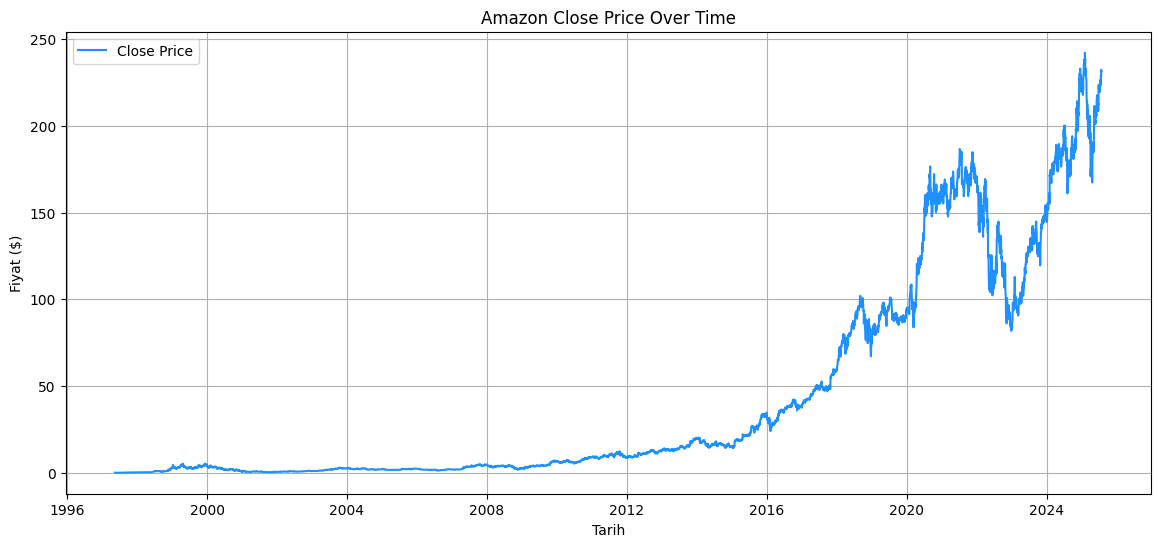

In [8]:
# Kapanış fiyatı zamanla nasıl değişmiş
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price', color='dodgerblue')
plt.title("Amazon Close Price Over Time")
plt.xlabel("Tarih")
plt.ylabel("Fiyat ($)")
plt.legend()
plt.grid(True)
plt.show()

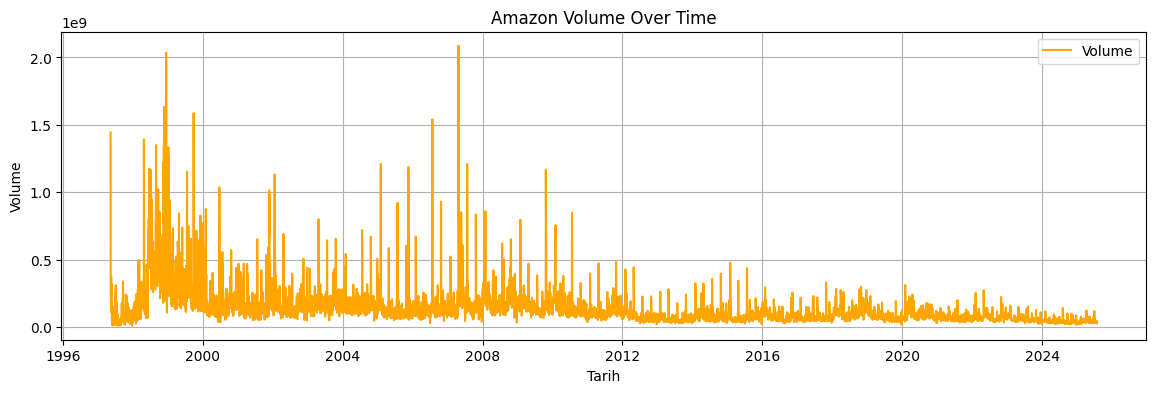

In [9]:
# İşlem hacmi zamanla nasıl değişmiş
plt.figure(figsize=(14,4))
plt.plot(df['Volume'], label='Volume', color='orange')
plt.title("Amazon Volume Over Time")
plt.xlabel("Tarih")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.show()

# Feature Engineering

Yeni özellikler eklendi:
- **Daily_Change**: Günlük değişim yüzdesi 
- **Volume_Change**: Hacim değişimi
- **Volatility**: Gün içi fiyat dalgalanması
- **Lag Features**: Geçmiş değerler (1-2 gün)
- **Moving Averages**: 5 ve 10 günlük ortalamalar

In [10]:
# Veri kaçağını önlemek için doğru feature engineering
df['Daily_Change'] = (df['Close'] - df['Open']) / df['Open']
df['Volume_Change'] = df['Volume'].pct_change() 
df['Volatility'] = df['High'] - df['Low']

# Zaman serisi için lag features ekliyoruz
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df['Volume_Lag1'] = df['Volume'].shift(1)

# Moving averages
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()

# Volatility indicators
df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Close']
df['Open_Close_Pct'] = (df['Close'] - df['Open']) / df['Open']

In [11]:
df.dropna(inplace=True)

# Target Değişken Oluşturma

Hedef değişken: Ertesi günün kapanış fiyatı

In [12]:
df["Target"]= df["Close"].shift(-1)
df.dropna(inplace=True)

# Train-Test Split

Zaman serisi için: %70 eğitim, %30 test (shuffle=False)

In [13]:
x= df.drop(["Target"], axis=1)
y= df["Target"]

In [14]:
split_ratio=0.7
split_index=int(len(df)*split_ratio)

In [15]:
# Eğitim seti
x_train = x.iloc[:split_index]
y_train = y.iloc[:split_index]

# Test seti
x_test = x.iloc[split_index:]
y_test = y.iloc[split_index:]

In [16]:
# Feature Scaling için StandardScaler
from sklearn.preprocessing import StandardScaler

# Scaler'ı sadece training set üzerinde fit et
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print("Feature scaling tamamlandı!")
print(f"Scaled eğitim seti şekli: {x_train_scaled.shape}")
print(f"Scaled test seti şekli: {x_test_scaled.shape}")

Feature scaling tamamlandı!
Scaled eğitim seti şekli: (4958, 15)
Scaled test seti şekli: (2125, 15)


In [17]:
print(f"Eğitim seti boyutu: {x_train.shape}")
print(f"Test seti boyutu: {x_test.shape}")

Eğitim seti boyutu: (4958, 15)
Test seti boyutu: (2125, 15)


# Model 1: Linear Regression

In [18]:
lr=LinearRegression() 
lr.fit(x_train,y_train)

LinearRegression()

In [19]:
y_pred=lr.predict(x_test)

In [20]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Performansı:\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR2: {r2:.4f}")

Linear Regression Performansı:
MAE: 1.8846
RMSE: 2.7731
R2: 0.9967


# Model 2: Random Forest

In [21]:
rf= RandomForestRegressor(random_state=42)
rf.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [22]:
y_pred_rf= rf.predict(x_test)

In [23]:
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test,y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest Performansı:\nMAE: {rf_mae:.4f}\nRMSE: {rf_rmse:.4f}\nR2: {rf_r2:.4f}")

Random Forest Performansı:
MAE: 84.6492
RMSE: 97.6093
R2: -3.0318


# Model 3: XGBoost

In [24]:
xgb= XGBRegressor(random_state=42)
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [25]:
y_pred_xgb= xgb.predict(x_test)

In [26]:
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb) 

print(f"XGBoost Performansı:\nMAE: {xgb_mae:.4f}\nRMSE: {xgb_rmse:.4f}\nR2: {xgb_r2:.4f}")

XGBoost Performansı:
MAE: 85.2862
RMSE: 98.2208
R2: -3.0824


In [27]:
print("\nModel Karşılaştırması:")
print(f"{'Model':<20} {'MAE':<10} {'RMSE':<10} {'R2':<10}")
print(f"{'LinearRegression':<20} {mae:.4f}     {rmse:.4f}     {r2:.4f}")
print(f"{'RandomForest':<20} {rf_mae:.4f}     {rf_rmse:.4f}     {rf_r2:.4f}")
print(f"{'XGBoost':<20} {xgb_mae:.4f}     {xgb_rmse:.4f}     {xgb_r2:.4f}")



Model Karşılaştırması:
Model                MAE        RMSE       R2        
LinearRegression     1.8846     2.7731     0.9967
RandomForest         84.6492     97.6093     -3.0318
XGBoost              85.2862     98.2208     -3.0824


# Model Sonuçları

## Temel Performans
- **Linear Regression**: En iyi sonuç (R² ≈ 0.997)
- **Random Forest & XGBoost**: Beklenenden düşük performans

## Analiz
Ağaç tabanlı modellerin düşük performansı, hisse senedi verilerinin trend yapısından kaynaklanmaktadır. Linear modeller bu tür veriler için daha uygundur.

# Hyperparameter Tuning

In [28]:
from sklearn.model_selection import GridSearchCV


In [29]:
# Hızlı test için minimal parametreler
param_grid = { 
    'n_estimators': [100, 200],              
    'max_depth': [10, 20],                 
    'min_samples_split': [2, 5],             
    'max_features': ['sqrt', None],          
}


In [30]:
rf_grid= RandomForestRegressor(random_state=42)

In [31]:
# Daha basit GridSearch 
grid_search_rf = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid,
    cv=2,  
    n_jobs=-1,
    verbose=1, 
    scoring='neg_mean_absolute_error'
)

In [32]:
grid_search_rf.fit(x_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'max_features': ['sqrt', None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error', verbose=1)

In [33]:
best_rf = grid_search_rf.best_estimator_

In [34]:
y_pred_rf_best = best_rf.predict(x_test)

In [35]:
mae = mean_absolute_error(y_test, y_pred_rf_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
r2 = r2_score(y_test, y_pred_rf_best)

print("En iyi parametreler:", grid_search_rf.best_params_)
print(f"\n Optimize Edilmiş Random Forest Performansı:\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR2: {r2:.4f}")

En iyi parametreler: {'max_depth': 20, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 100}

 Optimize Edilmiş Random Forest Performansı:
MAE: 84.6651
RMSE: 97.6248
R2: -3.0330


In [36]:
# XGBoost için daha hızlı GridSearch parametreleri
xgb_param_grid = {
    'n_estimators': [100, 200],              # Ağaç sayısı (3->2)
    'max_depth': [3, 6],                     # Maksimum derinlik (3->2)
    'learning_rate': [0.1, 0.2],             # Öğrenme oranı (3->2)
    'subsample': [0.8, 1.0],                 # Alt örnekleme
}

print(f"XGBoost toplam kombinasyon sayısı: {2*2*2*2} ")


XGBoost toplam kombinasyon sayısı: 16 


In [37]:
xgb_grid = XGBRegressor(random_state=42)

In [38]:
grid_search_xgb = GridSearchCV(estimator=xgb_grid,
                               param_grid=xgb_param_grid,
                               cv=3,
                               n_jobs=-1,
                               verbose=2,
                               scoring='neg_mean_absolute_error')

print("XGBoost GridSearch başlatılıyor...")
grid_search_xgb.fit(x_train, y_train)

XGBoost GridSearch başlatılıyor...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 6],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=2)

In [39]:
# En iyi XGBoost modelini al ve tahmin yap
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb_best = best_xgb.predict(x_test)

# Performans değerlendirmesi
xgb_mae_best = mean_absolute_error(y_test, y_pred_xgb_best)
xgb_rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_xgb_best))
xgb_r2_best = r2_score(y_test, y_pred_xgb_best)

print("En iyi XGBoost parametreleri:", grid_search_xgb.best_params_)
print(f"\nOptimize Edilmiş XGBoost Performansı:\nMAE: {xgb_mae_best:.4f}\nRMSE: {xgb_rmse_best:.4f}\nR2: {xgb_r2_best:.4f}")

En iyi XGBoost parametreleri: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}

Optimize Edilmiş XGBoost Performansı:
MAE: 85.2484
RMSE: 98.1382
R2: -3.0756


# Feature Scaling Test

In [40]:
# Scaled verilerle Random Forest
rf_scaled = RandomForestRegressor(random_state=42, n_estimators=200, max_depth=20)
rf_scaled.fit(x_train_scaled, y_train)
y_pred_rf_scaled = rf_scaled.predict(x_test_scaled)

rf_scaled_mae = mean_absolute_error(y_test, y_pred_rf_scaled)
rf_scaled_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_scaled))
rf_scaled_r2 = r2_score(y_test, y_pred_rf_scaled)

print(f"Scaled Random Forest Performansı:\nMAE: {rf_scaled_mae:.4f}\nRMSE: {rf_scaled_rmse:.4f}\nR2: {rf_scaled_r2:.4f}")

Scaled Random Forest Performansı:
MAE: 84.7154
RMSE: 97.6652
R2: -3.0364


In [41]:
# Scaled verilerle XGBoost
xgb_scaled = XGBRegressor(random_state=42, n_estimators=200, max_depth=6, learning_rate=0.1)
xgb_scaled.fit(x_train_scaled, y_train)
y_pred_xgb_scaled = xgb_scaled.predict(x_test_scaled)

xgb_scaled_mae = mean_absolute_error(y_test, y_pred_xgb_scaled)
xgb_scaled_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb_scaled))
xgb_scaled_r2 = r2_score(y_test, y_pred_xgb_scaled)

print(f"Scaled XGBoost Performansı:\nMAE: {xgb_scaled_mae:.4f}\nRMSE: {xgb_scaled_rmse:.4f}\nR2: {xgb_scaled_r2:.4f}")

Scaled XGBoost Performansı:
MAE: 85.2115
RMSE: 98.1010
R2: -3.0725


# Sonuçlar ve Çıkarımlar

## Performans Özeti
- **Linear Regression**: En başarılı model (R² ≈ 0.997)
- **Random Forest/XGBoost**: Trend verilerinde sınırlı performans

## Temel Bulgular
1. Hisse senedi verilerinde güçlü trend mevcuttur
2. Linear modeller trend yakalama konusunda üstündür  
3. Ağaç tabanlı modeller extrapolation yapamaz

## Geliştirme Önerileri
- Zaman serisi modelleri (ARIMA, Prophet)
- Deep Learning yaklaşımları (LSTM)
- Feature engineering iyileştirmeleri